# Standardization and Normalization

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/statistics/comments/1drvlyt/q_what_do_to_when_a_sw_and_ks_test_fail_on_a_pre/).

> I want to write a research article that has regression analysis in it. I normalized my independent variables and want to include in the article the results of a statistical test showing that all variables are normal. I normalized using the scale function in R and some custom normalization functions I found online but whatever I do the new data fails the Shapiro Wilkinson and KS test on some columns? What to do? 

There might be a few points of confusion here:

* One is the idea that the independent variables in a regression model have to follow a normal distribution. This is a common misconception. Ordinary least squares regression assumes that the *residuals* follow a normal distribution -- the dependent and independent variables don't have to.

* Another is the idea that statistical tests are useful for checking whether a variable follows a normal distribution. As I've explained in other articles, these tests don't do anything useful.

* The question might also reveal confusion about what "normalization" means. In the context of regression models, it usually means scaling a variable so its range is between 0 and 1. It sounds like OP might be using it to mean transforming a variable so it follows a normal distribution.

In general, transforming an independent variable to normal is not a good idea. It has no benefit, and it changes the estimated parameters for no justified reason. Let me explain.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/standardize.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

In [2]:
# install the empiricaldist library, if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

## Happiness

As an example, I'll use data from the [World Happiness Report](https://worldhappiness.report/), which uses survey data from 153 countries to explore the relationship between self-reported happiness and six potentially predictive factors:

* Income as represented by per capita GDP.

* Social support

* Healthy life expectancy at birth

* Freedom to make life choices

* Generosity

* Perceptions of corruption

The dependent variable, happiness, is the national average of responses to the "Cantril ladder question" used by the [Gallup World Poll](https://news.gallup.com/poll/122453/understanding-gallup-uses-cantril-scale.aspx):

> Please imagine a ladder with steps numbered from zero at the bottom to 10 at the top.
The top of the ladder represents the best possible life for you and the bottom of the ladder represents the worst possible life for you.
On which step of the ladder would you say you personally feel you stand at this time?  

The data they used is [available here](https://happiness-report.s3.amazonaws.com/2020/WHR20_DataForFigure2.1.xls).

In [3]:
download('https://happiness-report.s3.amazonaws.com/2020/WHR20_DataForFigure2.1.xls')

'WHR20_DataForFigure2.1.xls'

We can read the data into a Pandas `DataFrame`.

In [4]:
df = pd.read_excel('WHR20_DataForFigure2.1.xls')
df.head()

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900826,0.949172,-0.059482,0.195445,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.972317,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267
3,Iceland,Western Europe,7.5045,0.059616,7.621347,7.387653,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710,1.972317,1.326502,1.547567,1.000843,0.661981,0.362330,0.144541,2.460688
4,Norway,Western Europe,7.4880,0.034837,7.556281,7.419719,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218,1.972317,1.424207,1.495173,1.008072,0.670201,0.287985,0.434101,2.168266


I'll select the columns we're interested in and give them shorter names.

In [5]:
data = pd.DataFrame()

data['ladder'] = df['Ladder score']
data['log_gdp'] = df['Logged GDP per capita']
data['social'] = df['Social support']
data['life_exp'] = df['Healthy life expectancy']
data['freedom'] = df['Freedom to make life choices']
data['generosity'] = df['Generosity']
data['corruption'] = df['Perceptions of corruption']

Notice that GDP is already on a log scale, which is generally a good idea.
The other variables are in a variety of units and different scales.

Now, contrary to the advice OP was given, let's run a regression model without even looking at the data.

In [6]:
import statsmodels.formula.api as smf

formula = 'ladder ~ log_gdp + social + life_exp + freedom + generosity + corruption'

results_raw = smf.ols(formula, data=data).fit()
results_raw.params

Intercept    -2.059377
log_gdp       0.229079
social        2.723318
life_exp      0.035307
freedom       1.776815
generosity    0.410566
corruption   -0.628162
dtype: float64

Because the independent variables are on different scales, the estimated parameters are in different units.
For example, `life_exp` is healthy life expectancy at birth in units of years, so the estimated parameter, 0.035, indicates that a difference of one year of life expectancy between countries is associated with an increase of 0.035 units on the Cantril ladder.

Now let's check retroactively whether this dataset is consistent with the assumption that the residuals follow a normal distribution.
I'll use the following functions to compare the CDF of the residuals to a normal model with the same mean and standard deviation. 

In [7]:
from scipy.stats import norm
from empiricaldist import Cdf

def make_normal_model(sample):
    """Make a Cdf of a normal distribution.
    
    sample: sequence of numbers
    
    returns: Cdf object
    """
    m, s = sample.mean(), sample.std()
    qs = np.linspace(m - 4 * s, m + 4 * s, 101)
    ps = norm.cdf(qs, m, s)
    return Cdf(ps, qs)

In [8]:
def plot_normal_model(sample, **options):
    """Plot the Cdf of a sample and a normal model.
    
    sample: sequence of numbers
    """
    cdf_model = make_normal_model(sample)
    cdf_data = Cdf.from_seq(sample)

    cdf_model.plot(color='gray')
    cdf_data.plot(**options)

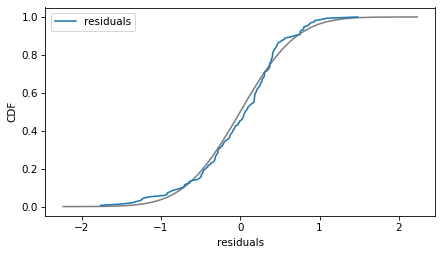

In [9]:
plot_normal_model(results_raw.resid, label='residuals')
decorate(xlabel='residuals', ylabel='CDF')

The normal model fits the residuals well enough that the deviations are not a concern.
This regression model is just fine with no transformations required.

But suppose we follow the advice OP received and check whether the dependent and independent variables follow normal distributions.

## Looking for trouble

Here are the distributions of the variables compared to a normal model.
Sometimes the model fits pretty well, sometimes not.

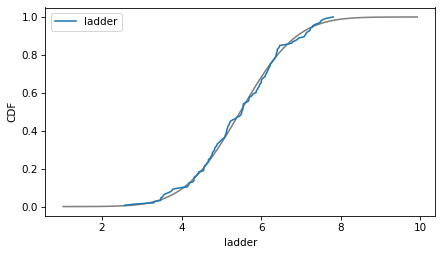

In [10]:
column = 'ladder'
plot_normal_model(data[column], label=column)
decorate(xlabel=column, ylabel='CDF')

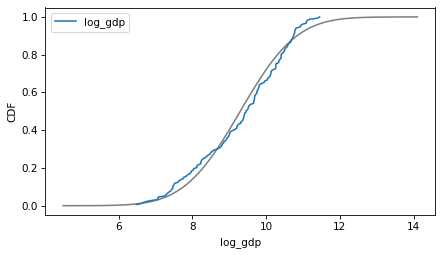

In [11]:
column = 'log_gdp'
plot_normal_model(data[column], label=column)
decorate(xlabel=column, ylabel='CDF')

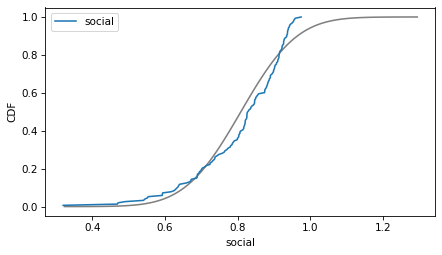

In [12]:
column = 'social'
plot_normal_model(data[column], label=column)
decorate(xlabel=column, ylabel='CDF')

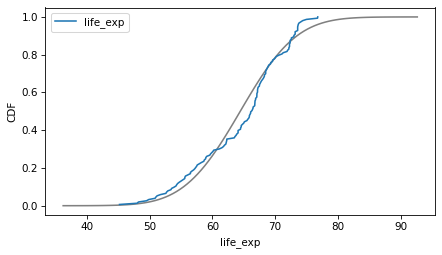

In [13]:
column = 'life_exp'
plot_normal_model(data[column], label=column)
decorate(xlabel=column, ylabel='CDF')

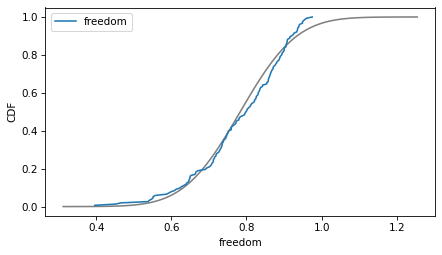

In [14]:
column = 'freedom'
plot_normal_model(data[column], label=column)
decorate(xlabel=column, ylabel='CDF')

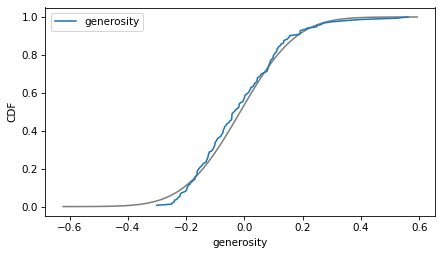

In [15]:
column = 'generosity'
plot_normal_model(data[column], label=column)
decorate(xlabel=column, ylabel='CDF')

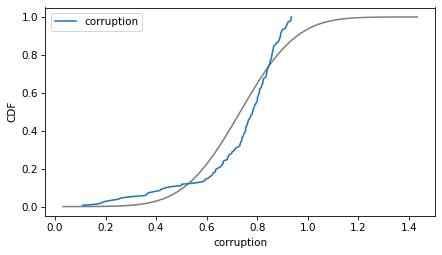

In [16]:
column = 'corruption'
plot_normal_model(data[column], label=column)
decorate(xlabel=column, ylabel='CDF')

If we ran a statistical test, most of these would fail. But we don't care -- regression models don't require these variables to follow normal distributions. And when we make this kind of comparison across countries, there no reason to expect them to.

## Standardize

Nevertheless, there are reasons we might want to transform the independent variables before running a regression model -- one is to quantify the "importance" of the different factors. We can do that by standardizing the variables, which means transforming them to have mean 0 and standard deviation 1.

In the untransformed variables, the means vary in magnitude from about 0.1 to 64.

In [17]:
data.mean().sort_values()

generosity    -0.014568
corruption     0.733120
freedom        0.783360
social         0.808721
ladder         5.473240
log_gdp        9.295706
life_exp      64.445529
dtype: float64

And the standard deviations vary from about 0.1 to 7.

In [18]:
data.std().sort_values()

freedom       0.117786
social        0.121453
generosity    0.151809
corruption    0.175172
ladder        1.112270
log_gdp       1.201588
life_exp      7.057848
dtype: float64

And, as I've already noted, they are expressed in different units.
There is no meaningful way to compare the parameter of `life_exp`, which is steps of the Cantril ladder per year of life expectancy, with the parameter of `corruption`, which is in steps of the ladder per percentage point.
But we can make these comparisons meaningful by standardizing the variables -- that is, subtracting off the mean and dividing by the standard deviation.

In [19]:
standardized = (data - data.mean()) / data.std()

After transformation, the means are all close to 0.

In [20]:
standardized.mean()

ladder       -2.786442e-16
log_gdp       6.966105e-16
social       -3.715256e-16
life_exp     -5.108477e-16
freedom      -3.250849e-16
generosity   -2.612289e-17
corruption   -2.554239e-16
dtype: float64

And the standard deviations are all close to 1.

In [21]:
standardized.std()

ladder        1.0
log_gdp       1.0
social        1.0
life_exp      1.0
freedom       1.0
generosity    1.0
corruption    1.0
dtype: float64

Here's the regression with the transformed variables.

In [22]:
results_standardized = smf.ols(formula, data=standardized).fit()
results_standardized.params

Intercept    -4.072828e-16
log_gdp       2.474749e-01
social        2.973701e-01
life_exp      2.240379e-01
freedom       1.881597e-01
generosity    5.603632e-02
corruption   -9.892975e-02
dtype: float64

The intercept is close to 0 -- that's a consequence of how the math works out.
And now the magnitudes of the parameters indicate how much a change in each independent variable, expressed as a multiple of its standard deviation, is associated with a change in the dependent variables, also as a multiple of its standard deviation.

By this metric, `social` is the most important factor, followed closely by `log_gdp` and `life_exp`. `corruption` is the least important factor, at least as its quantified by this variable.

In [23]:
results_standardized.params.sort_values(ascending=False)

social        2.973701e-01
log_gdp       2.474749e-01
life_exp      2.240379e-01
freedom       1.881597e-01
generosity    5.603632e-02
Intercept    -4.059253e-16
corruption   -9.892975e-02
dtype: float64

## Normalizing

An alternative to standardization is normalization, which transforms a variable so its range is between 0 and 1.
To be honest, I'm not sure what the point of normalization is -- it makes the results a little harder to interpret, and it doesn't have any advantages I can think of.

But just for completeness, here's how it's done.


In [24]:
normalized = (data - data.min()) / (data.max() - data.min())

As intended, the normalized variables have the same range.

In [25]:
normalized.min()

ladder        0.0
log_gdp       0.0
social        0.0
life_exp      0.0
freedom       0.0
generosity    0.0
corruption    0.0
dtype: float64

In [26]:
normalized.max()

ladder        1.0
log_gdp       1.0
social        1.0
life_exp      1.0
freedom       1.0
generosity    1.0
corruption    1.0
dtype: float64

But as a result they have somewhat different means and standard deviations.

In [27]:
normalized.mean()

ladder        0.554455
log_gdp       0.565357
social        0.746725
life_exp      0.608947
freedom       0.668690
generosity    0.332345
corruption    0.754826
dtype: float64

In [28]:
normalized.std()

ladder        0.212192
log_gdp       0.242351
social        0.185365
life_exp      0.223317
freedom       0.203633
generosity    0.176200
corruption    0.212124
dtype: float64

Here's the regression with normalized variables.

In [29]:
results_normalized = smf.ols(formula, data=normalized).fit()
results_normalized.params

Intercept    -0.030706
log_gdp       0.216678
social        0.340407
life_exp      0.212877
freedom       0.196069
generosity    0.067483
corruption   -0.098962
dtype: float64

We'll look more closely at those results soon, but first let's look at one more preprocessing option, transforming values to follow a normal distribution.

## Transform to normal

Here's how we transform values to a normal distribution. 

In [30]:
n = len(data)
ps = np.arange(1, n+1) / (n + 1)
zs = norm.ppf(ps)

transformed = data.copy()
for column in transformed.columns:
    transformed.sort_values(column, inplace=True)
    transformed[column] = zs

The `ps` are the cumulative probabilities; the `zs` are the corresponding quantiles in a standard normal distribution (`ppf` computes the "percent point function" which is an unnecessary name for the inverse CDF).
Inside the loop, we sort `transformed` by one of the columns and then assign the `zs` in that order.

The transformed means are all close to 0.

In [31]:
transformed.mean()

ladder        4.644070e-17
log_gdp       4.644070e-17
social        1.161018e-17
life_exp      0.000000e+00
freedom       0.000000e+00
generosity    4.644070e-17
corruption   -4.644070e-17
dtype: float64

And the standard deviations are close to 1 (but not exact because the tails of the distribution are cut off).

In [32]:
transformed.std()

ladder        0.975034
log_gdp       0.975034
social        0.975034
life_exp      0.975034
freedom       0.975034
generosity    0.975034
corruption    0.975034
dtype: float64

As intended, the transformed variables follow a normal distribution.

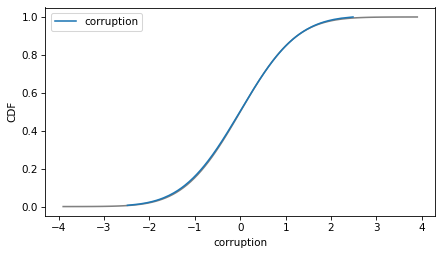

In [33]:
plot_normal_model(transformed['corruption'], label='corruption')
decorate(ylabel='CDF')

Here's the regression model with the transformed values.

In [34]:
results_transformed = smf.ols(formula, data=transformed).fit()
results_transformed.params

Intercept     5.425248e-18
log_gdp       2.382770e-01
social        3.642517e-01
life_exp      1.951131e-01
freedom       2.028179e-01
generosity    3.216042e-02
corruption   -4.517596e-02
dtype: float64

Now let's compare the estimated parameters with the three transformations.

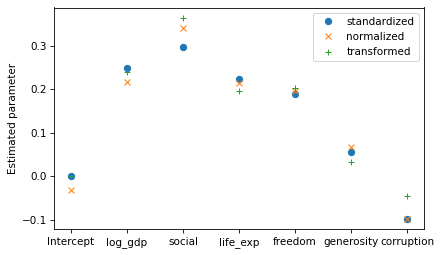

In [35]:
results_standardized.params.plot(style='o', label='standardized')
results_normalized.params.plot(style='x', label='normalized')
results_transformed.params.plot(style='+', label='transformed')

decorate(ylabel='Estimated parameter')

The results with standardized variables are the easiest to interpret, so in that sense they are "right". The other transformations have no advantages over standardization, and they produce somewhat different parameters.

## Discussion

Regression does not require the dependent or independent variables to follow a normal distribution.
It only assumes that the distribution of residuals is approximately normal, and even that requirement is not strict -- regression is quite robust.

You do not need to check whether any of these variables follow a normal distribution, and you definitely should not use a statistical test.

As part of your usual exploratory data analysis, you should look at the distribution of all variables, but that's primarily to detect any anomalies, outliers, or really extreme distributions -- not to check whether they fit normal distributions.

If you want to use the parameters of the model to quantify the importance of the independent variables, use standardization. There's no reason to use normalization, and definitely no reason to transform to a normal distribution.

[*Data Q&A: Answering the real questions with Python*](https://allendowney.github.io/DataQnA/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)